In [1]:
%load_ext autoreload
%autoreload 2

import copy

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from htc.context.models.context_evaluation import compare_context_runs, glove_runs
from htc.context.models.visualization import ranking_figure, ranking_legend
from htc.context.settings_context import settings_context
from htc.evaluation.ranking import BootstrapRankingSubjects
from htc.fonts.set_font import set_font
from htc.models.common.torch_helpers import move_batch_gpu
from htc.models.common.transforms import HTCTransformation
from htc.models.image.DatasetImage import DatasetImage
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config

set_font(24)

In [2]:
task_mapping = {k: v for k, v in settings_context.task_name_mapping.items() if k not in ["semantic", "no-glove"]}

runs = settings_context.best_transform_runs.values()
df = compare_context_runs(runs, test=True, keep_subjects=True)
df = df.query("dataset in @task_mapping.keys()")
df.replace({"network": r"context_([^\d]+)_.*"}, {"network": r"\1"}, regex=True, inplace=True)

# Add results for the glove dataset
df = pd.concat([df, glove_runs(keep_subjects=True)])
df

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_model_comparison                 

,network,dataset,subject_name,label_index,dice_metric,surface_distance_metric,surface_dice_metric_mean,label_name
0,baseline,isolation_0,P072,6,0.127945,198.754832,0.305158,stomach
1,baseline,isolation_0,P062,6,0.493575,111.534380,0.440030,stomach
2,baseline,isolation_0,P043,6,0.041198,16.088644,0.537480,stomach
3,baseline,isolation_0,P046,6,0.540506,5.498804,0.685887,stomach
4,baseline,isolation_0,P068,6,0.770752,7.560082,0.693965,stomach
...,...,...,...,...,...,...,...,...
48,hide_and_seek,glove,P062,18,0.661349,9.187539,0.287080,kidney_with_Gerotas_fascia
49,hide_and_seek,glove,P068,0,0.841658,10.187638,0.591069,background
50,hide_and_seek,glove,P062,0,0.988462,1.413036,0.880657,background
51,hide_and_seek,glove,P072,0,0.885334,4.818116,0.752491,background


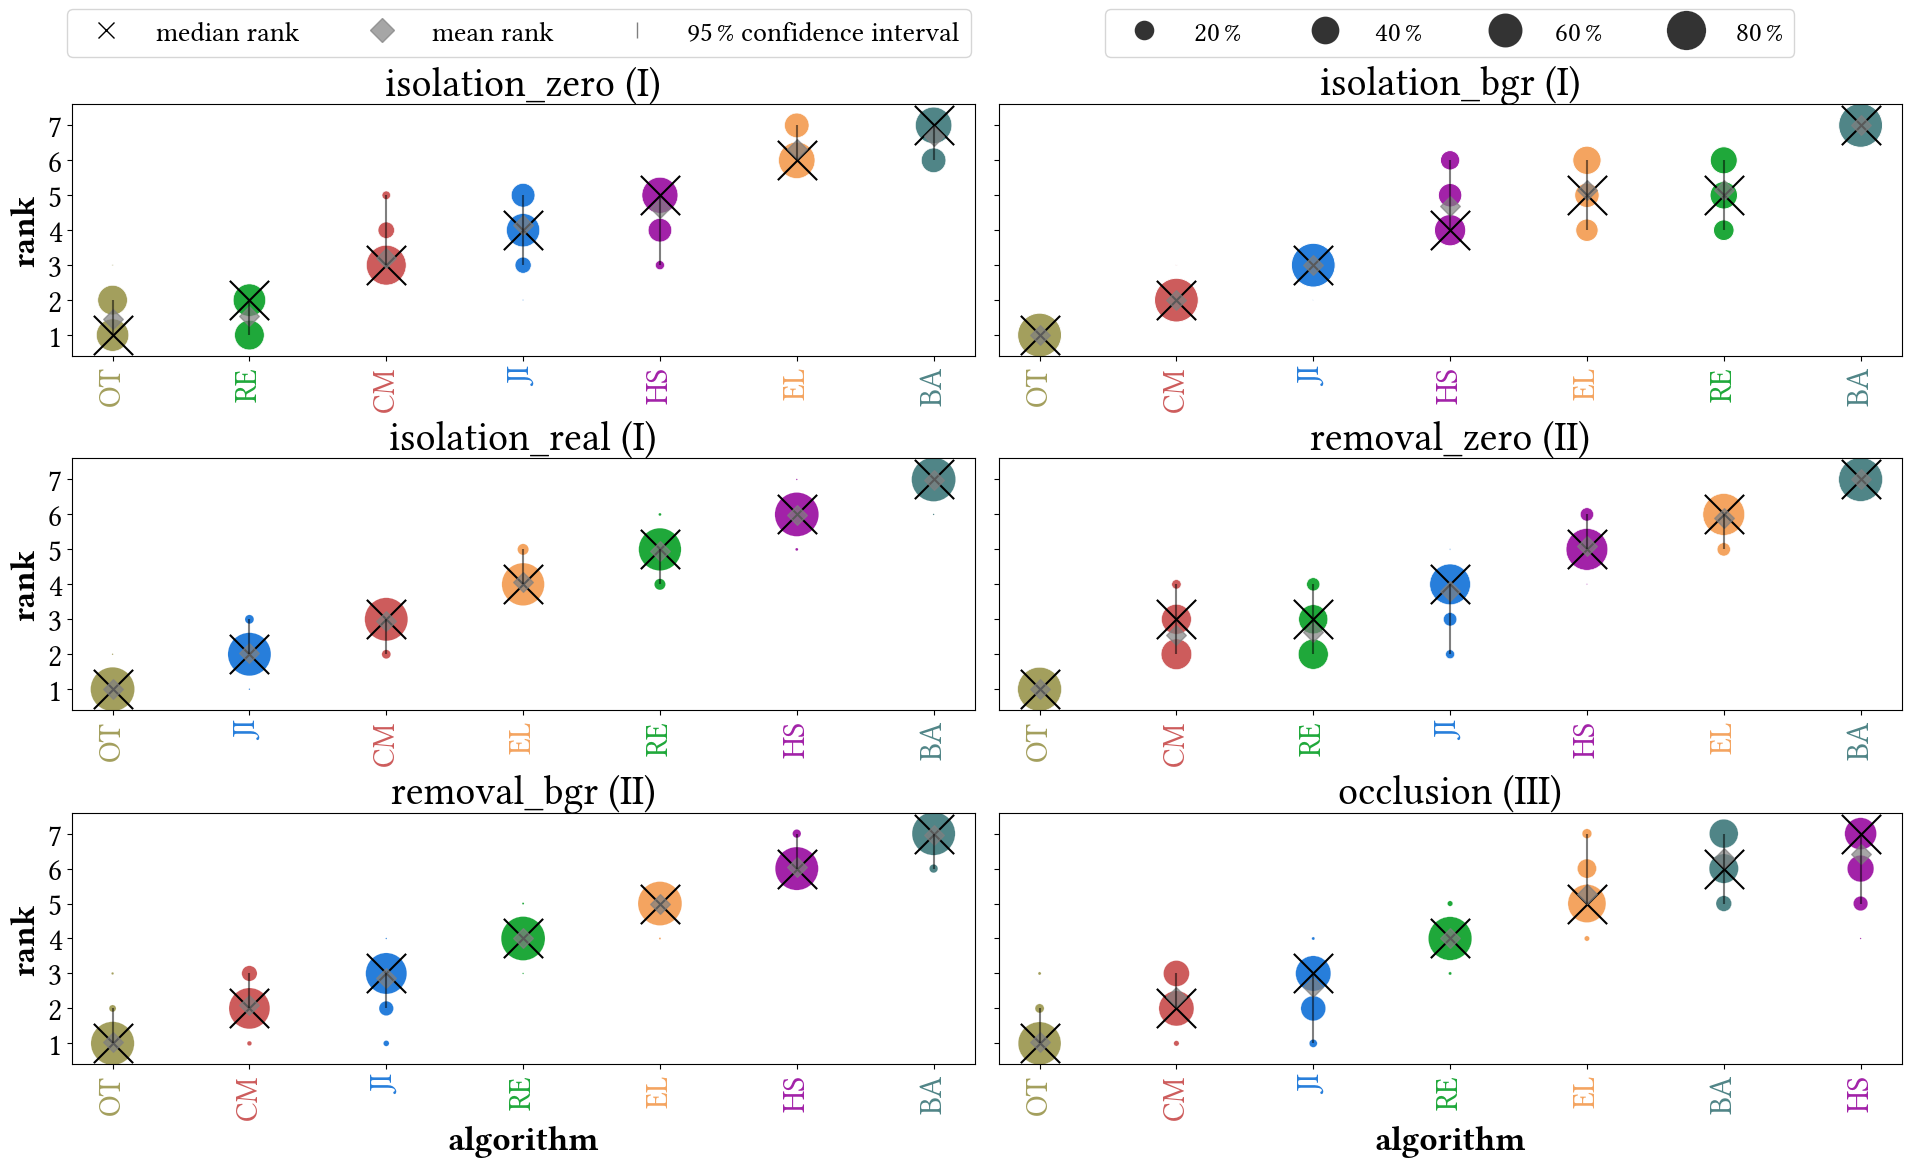

In [3]:
np.random.seed(0)
ranking = BootstrapRankingSubjects(
    df, task="dataset", algorithm="network", case="label_name", value="dice_metric", subject_column="subject_name"
)

fig = ranking_figure(ranking, task_mapping)
for ax in fig.get_axes():
    ax.set_xlabel(ax.get_xlabel(), fontweight="bold")
    ax.set_ylabel(ax.get_ylabel(), fontweight="bold")
fig.savefig(settings_context.paper_extended_dir / "ranking_DSC.pdf", bbox_inches="tight");

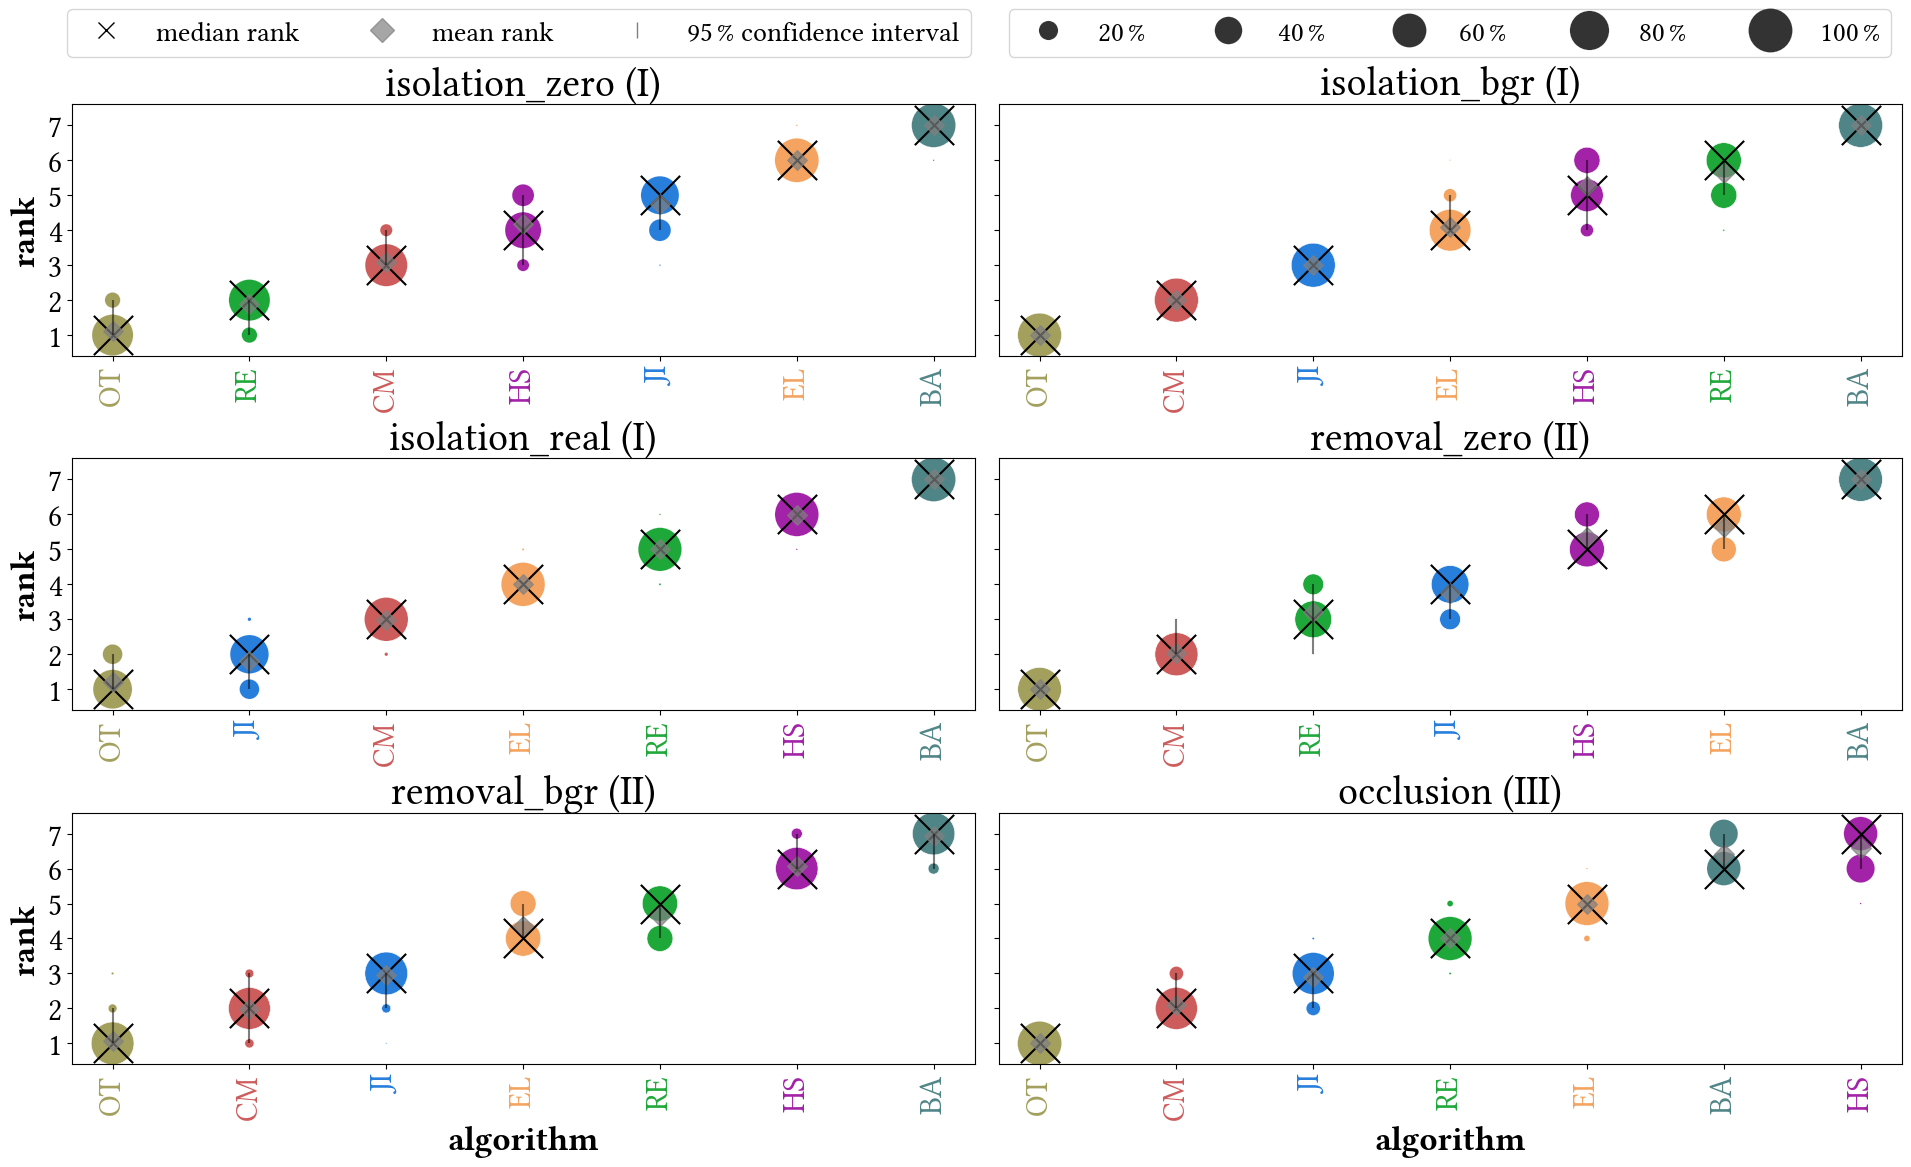

In [4]:
np.random.seed(0)
ranking_nsd = BootstrapRankingSubjects(
    df,
    task="dataset",
    algorithm="network",
    case="label_name",
    value=settings_seg.nsd_aggregation_short,
    subject_column="subject_name",
)

fig = ranking_figure(ranking_nsd, task_mapping)
for ax in fig.get_axes():
    ax.set_xlabel(ax.get_xlabel(), fontweight="bold")
    ax.set_ylabel(ax.get_ylabel(), fontweight="bold")
fig.savefig(settings_context.paper_extended_dir / "ranking_NSD.pdf", bbox_inches="tight");

[WARNING][py.warnings]                                                                                   warnings.py:110
/home/j562r/miniconda3/envs/htc2/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning:                 
Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please                     
specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for                     
details.                                                                                                                
  warnings.warn(                                                                                                        
                                                                                                                        

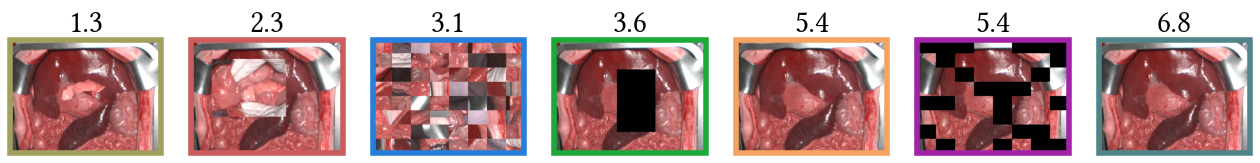

In [5]:
example_paths = [
    DataPath.from_image_name("P047#2020_02_07_17_29_03"),
    DataPath.from_image_name("P070#2020_07_24_19_57_13"),
    DataPath.from_image_name("P044#2020_02_01_09_58_04"),
    DataPath.from_image_name("P068#2020_07_20_18_22_06"),
    DataPath.from_image_name("P041#2019_12_14_12_01_09"),
    DataPath.from_image_name("P057#2020_03_13_18_44_07"),
    DataPath.from_image_name("P061#2020_05_15_10_28_04"),
    DataPath.from_image_name("P072#2020_08_08_12_56_21"),
    DataPath.from_image_name("P045#2020_02_05_10_54_19"),
]

trans_images = {}
selected_image = 0

for name, trans in settings_context.transforms.items():
    if name == "elastic":
        torch.manual_seed(0)
    elif name == "cut_mix":
        torch.manual_seed(1)
    else:
        torch.manual_seed(42)

    trans = copy.deepcopy(trans)
    trans["p"] = 1
    config = Config({
        "input/n_channels": 3,
        "input/transforms_gpu": [trans],
        "label_mapping": settings_seg.label_mapping,
    })

    dataset = DatasetImage(example_paths, train=False, config=config)
    dataloader = DataLoader(dataset, batch_size=len(example_paths))
    batch = next(iter(dataloader))

    batch_gpu = move_batch_gpu(batch)
    aug = HTCTransformation.parse_transforms(config["input/transforms_gpu"], config=config)
    batch_transformed = HTCTransformation.apply_valid_transforms(batch_gpu, aug)

    trans_images[name] = batch_transformed["features"][selected_image].cpu()

trans_images["baseline"] = batch["features"][0]

df_overall = (
    ranking.statistics.groupby("algorithm", as_index=True)["mean_rank"].mean().reset_index().sort_values("mean_rank")
)
fig = ranking_legend(df_overall["algorithm"].tolist(), df_overall["mean_rank"].tolist(), trans_images)
fig.savefig(settings_context.paper_extended_dir / "augmentation_legend_DSC.pdf", bbox_inches="tight", dpi=300)

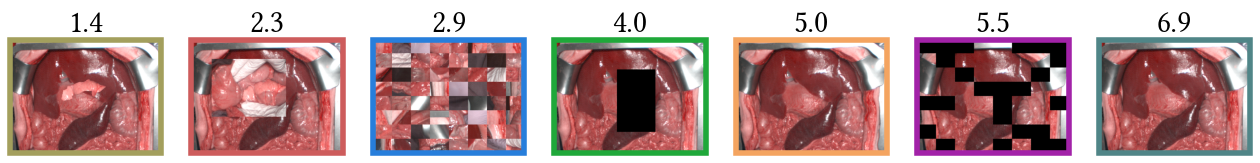

In [6]:
df_overall_nsd = (
    ranking_nsd.statistics.groupby("algorithm", as_index=True)["mean_rank"]
    .mean()
    .reset_index()
    .sort_values("mean_rank")
)
fig = ranking_legend(df_overall_nsd["algorithm"].tolist(), df_overall_nsd["mean_rank"].tolist(), trans_images)
fig.savefig(settings_context.paper_extended_dir / "augmentation_legend_NSD.pdf", bbox_inches="tight", dpi=300)